In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import time
from datetime import datetime

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Custom layer with mixed activations
class MixedActivationLayer(nn.Module):
    def __init__(self, in_features, neurons_per_activation):
        """
        neurons_per_activation: list of tuples (activation_function, num_neurons)
        """
        super(MixedActivationLayer, self).__init__()
        self.in_features = in_features
        self.neurons_per_activation = neurons_per_activation
        
        # Calculate total neurons
        self.out_features = sum(num for _, num in neurons_per_activation)
        
        # Create the linear layer
        self.linear = nn.Linear(in_features, self.out_features)
        
        # Store cumulative indices for splitting
        self.split_indices = np.cumsum([num for _, num in neurons_per_activation])
        
    def forward(self, x):
        x = self.linear(x)
        
        # Split the output and apply different activations
        outputs = []
        start_idx = 0
        
        for (activation, _), end_idx in zip(self.neurons_per_activation, self.split_indices):
            split = x[:, start_idx:end_idx]
            outputs.append(activation(split))
            start_idx = end_idx
            
        return torch.cat(outputs, dim=1)

# Define models
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

class MixedActivationModel(nn.Module):
    def __init__(self):
        super(MixedActivationModel, self).__init__()
        
        # First layer with mixed activations
        self.mixed_layer = MixedActivationLayer(
            in_features=2,
            neurons_per_activation=[
                (nn.ReLU(), 4),
                (nn.Tanh(), 4),
                (nn.Sigmoid(), 4)
            ]
        )
        
        # Rest of the network
        self.layers = nn.Sequential(
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.mixed_layer(x)
        return self.layers(x)

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, device='cpu'):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

Epoch 0: Train Loss = 0.0613, Val Loss = 0.0624
Epoch 10: Train Loss = 0.0257, Val Loss = 0.0283
Epoch 20: Train Loss = 0.0142, Val Loss = 0.0165
Epoch 30: Train Loss = 0.0062, Val Loss = 0.0079
Epoch 40: Train Loss = 0.0034, Val Loss = 0.0045
Epoch 50: Train Loss = 0.0023, Val Loss = 0.0030
Epoch 60: Train Loss = 0.0016, Val Loss = 0.0021
Epoch 70: Train Loss = 0.0012, Val Loss = 0.0016
Epoch 80: Train Loss = 0.0010, Val Loss = 0.0013
Epoch 90: Train Loss = 0.0008, Val Loss = 0.0011
Epoch 0: Train Loss = 0.0613, Val Loss = 0.0660
Epoch 10: Train Loss = 0.0243, Val Loss = 0.0285
Epoch 20: Train Loss = 0.0112, Val Loss = 0.0122
Epoch 30: Train Loss = 0.0052, Val Loss = 0.0053
Epoch 40: Train Loss = 0.0031, Val Loss = 0.0029
Epoch 50: Train Loss = 0.0020, Val Loss = 0.0018
Epoch 60: Train Loss = 0.0015, Val Loss = 0.0013
Epoch 70: Train Loss = 0.0011, Val Loss = 0.0010
Epoch 80: Train Loss = 0.0009, Val Loss = 0.0008
Epoch 90: Train Loss = 0.0007, Val Loss = 0.0007


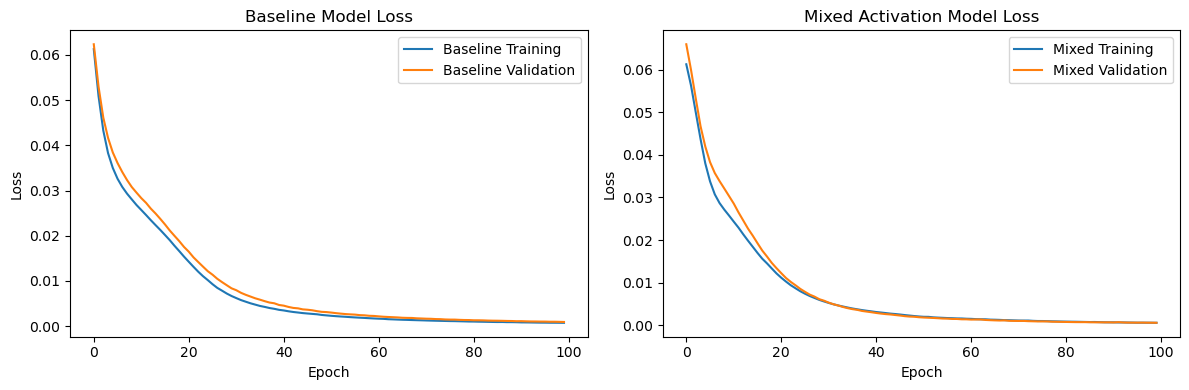


Test Results:
Baseline Model - MSE Loss: 0.0009
Mixed Activation Model - MSE Loss: 0.0006


In [2]:
# Generate synthetic data
np.random.seed(42)
X = np.random.uniform(-2, 2, (1000, 2))
y = np.sin(X[:, 0]) * np.cos(X[:, 1])
y = (y - y.min()) / (y.max() - y.min())  # Normalize to [0,1]

# Split data and convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# Create data loaders
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
baseline_model = BaselineModel().to(device)
mixed_model = MixedActivationModel().to(device)

# Training parameters
criterion = nn.MSELoss()
baseline_optimizer = optim.Adam(baseline_model.parameters())
mixed_optimizer = optim.Adam(mixed_model.parameters())

# Train models
baseline_train_losses, baseline_val_losses = train_model(
    baseline_model, train_loader, test_loader, criterion, baseline_optimizer
)
mixed_train_losses, mixed_val_losses = train_model(
    mixed_model, train_loader, test_loader, criterion, mixed_optimizer
)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(baseline_train_losses, label='Baseline Training')
plt.plot(baseline_val_losses, label='Baseline Validation')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mixed_train_losses, label='Mixed Training')
plt.plot(mixed_val_losses, label='Mixed Validation')
plt.title('Mixed Activation Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final test performance
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)

baseline_test_loss = evaluate_model(baseline_model, test_loader, criterion, device)
mixed_test_loss = evaluate_model(mixed_model, test_loader, criterion, device)

print("\nTest Results:")
print(f"Baseline Model - MSE Loss: {baseline_test_loss:.4f}")
print(f"Mixed Activation Model - MSE Loss: {mixed_test_loss:.4f}")

In [ ]:
# Generate spiral dataset
def generate_spirals(n_samples_per_class, n_classes, noise=0.5):
    X = []
    y = []
    
    for i in range(n_classes):
        r = np.linspace(0.0, 1, n_samples_per_class)
        t = np.linspace(i * 4, (i + 1) * 4, n_samples_per_class) + np.random.randn(n_samples_per_class) * noise
        
        x = np.column_stack([
            r * np.sin(t * 2.5),
            r * np.cos(t * 2.5),
            np.sin(t * 0.5),  # Adding third dimension
            np.cos(t * 0.5)   # Adding fourth dimension
        ])
        
        X.append(x)
        y.extend([i] * n_samples_per_class)
    
    return np.vstack(X), np.array(y)

# Custom layer with mixed activations
class MixedActivationLayer(nn.Module):
    def __init__(self, in_features, neurons_per_activation):
        super(MixedActivationLayer, self).__init__()
        self.in_features = in_features
        self.neurons_per_activation = neurons_per_activation
        self.out_features = sum(num for _, num in neurons_per_activation)
        self.linear = nn.Linear(in_features, self.out_features)
        self.split_indices = np.cumsum([num for _, num in neurons_per_activation])
        
    def forward(self, x):
        x = self.linear(x)
        outputs = []
        start_idx = 0
        
        for (activation, _), end_idx in zip(self.neurons_per_activation, self.split_indices):
            split = x[:, start_idx:end_idx]
            outputs.append(activation(split))
            start_idx = end_idx
            
        return torch.cat(outputs, dim=1)

# Complex baseline model
class ComplexBaselineModel(nn.Module):
    def __init__(self, num_classes):
        super(ComplexBaselineModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

# Complex mixed activation model
class ComplexMixedModel(nn.Module):
    def __init__(self, num_classes):
        super(ComplexMixedModel, self).__init__()
        
        # First mixed layer
        self.mixed_layer1 = MixedActivationLayer(
            in_features=4,
            neurons_per_activation=[
                (nn.ReLU(), 48),
                (nn.GELU(), 40),
                (nn.Tanh(), 40)
            ]
        )
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second mixed layer
        self.mixed_layer2 = MixedActivationLayer(
            in_features=128,
            neurons_per_activation=[
                (nn.ReLU(), 96),
                (nn.GELU(), 80),
                (nn.Tanh(), 80)
            ]
        )
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third mixed layer
        self.mixed_layer3 = MixedActivationLayer(
            in_features=256,
            neurons_per_activation=[
                (nn.ReLU(), 48),
                (nn.GELU(), 40),
                (nn.Tanh(), 40)
            ]
        )
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.mixed_layer1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.mixed_layer2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = self.mixed_layer3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        
        return self.final_layers(x)

# Training function with learning rate scheduling
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=150, device='cpu'):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0
    best_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted == y_batch).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, '
                  f'Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%')
    
    # Restore best model
    model.load_state_dict(best_state)
    return train_losses, val_losses, train_accs, val_accs

Epoch 0: Train Loss = 0.8534, Val Loss = 0.6090, Train Acc = 59.83%, Val Acc = 66.20%
Epoch 10: Train Loss = 0.4951, Val Loss = 0.4815, Train Acc = 74.47%, Val Acc = 75.60%
Epoch 20: Train Loss = 0.4920, Val Loss = 0.4617, Train Acc = 74.40%, Val Acc = 76.00%
Epoch 30: Train Loss = 0.4751, Val Loss = 0.4628, Train Acc = 75.38%, Val Acc = 77.30%
Epoch 40: Train Loss = 0.4699, Val Loss = 0.4633, Train Acc = 76.10%, Val Acc = 76.50%
Epoch 50: Train Loss = 0.4681, Val Loss = 0.4676, Train Acc = 75.95%, Val Acc = 76.10%
Epoch 60: Train Loss = 0.4661, Val Loss = 0.4660, Train Acc = 75.55%, Val Acc = 77.30%
Epoch 70: Train Loss = 0.4552, Val Loss = 0.4633, Train Acc = 76.20%, Val Acc = 77.90%
Epoch 80: Train Loss = 0.4584, Val Loss = 0.4634, Train Acc = 75.45%, Val Acc = 76.90%
Epoch 90: Train Loss = 0.4538, Val Loss = 0.4635, Train Acc = 76.53%, Val Acc = 77.40%
Epoch 100: Train Loss = 0.4530, Val Loss = 0.4631, Train Acc = 75.70%, Val Acc = 77.20%
Epoch 110: Train Loss = 0.4530, Val Loss = 

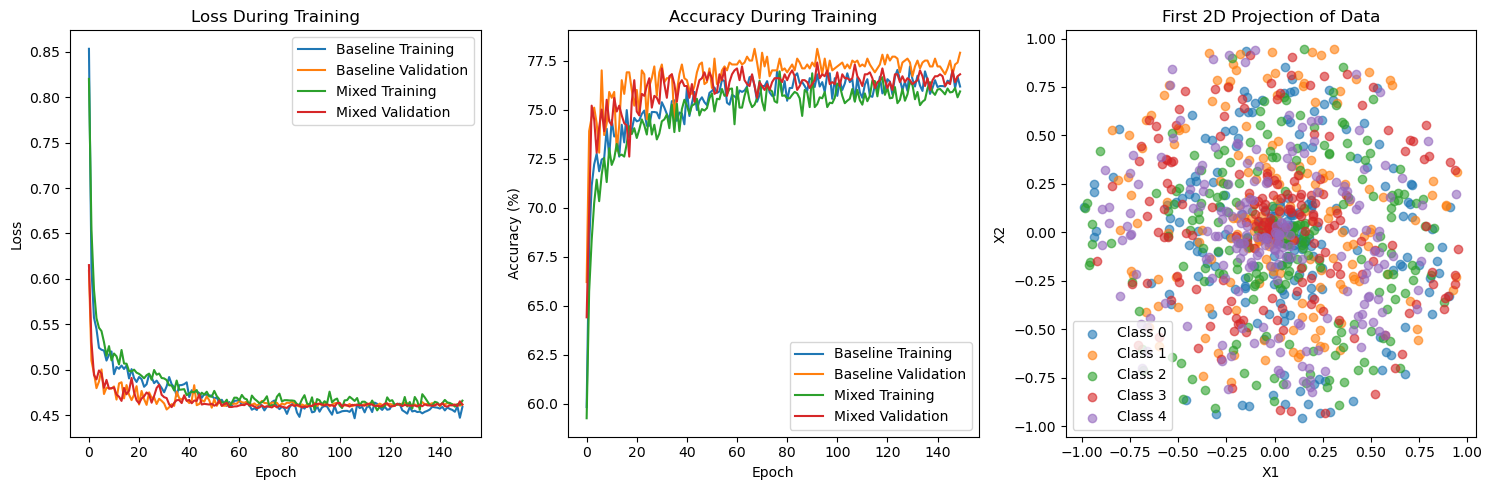


Final Test Results:
Baseline Model - Loss: 0.4618, Accuracy: 77.90%
Mixed Activation Model - Loss: 0.4615, Accuracy: 76.80%


In [4]:
# Generate and prepare data
X, y = generate_spirals(1000, 5, noise=0.5)  # 5 classes, 1000 samples each
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
baseline_model = ComplexBaselineModel(num_classes=5).to(device)
mixed_model = ComplexMixedModel(num_classes=5).to(device)

# Training parameters
criterion = nn.CrossEntropyLoss()
baseline_optimizer = optim.AdamW(baseline_model.parameters(), lr=0.001, weight_decay=0.01)
mixed_optimizer = optim.AdamW(mixed_model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate schedulers
baseline_scheduler = optim.lr_scheduler.ReduceLROnPlateau(baseline_optimizer, mode='min', factor=0.5, patience=10)
mixed_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mixed_optimizer, mode='min', factor=0.5, patience=10)

# Train models
baseline_results = train_model(
    baseline_model, train_loader, test_loader, criterion, 
    baseline_optimizer, baseline_scheduler
)
mixed_results = train_model(
    mixed_model, train_loader, test_loader, criterion, 
    mixed_optimizer, mixed_scheduler
)

# Plot results
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(baseline_results[0], label='Baseline Training')
plt.plot(baseline_results[1], label='Baseline Validation')
plt.plot(mixed_results[0], label='Mixed Training')
plt.plot(mixed_results[1], label='Mixed Validation')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(baseline_results[2], label='Baseline Training')
plt.plot(baseline_results[3], label='Baseline Validation')
plt.plot(mixed_results[2], label='Mixed Training')
plt.plot(mixed_results[3], label='Mixed Validation')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Visualize data (first two dimensions)
plt.subplot(1, 3, 3)
for i in range(5):
    mask = y_test.numpy() == i
    plt.scatter(X_test[mask, 0], X_test[mask, 1], label=f'Class {i}', alpha=0.6)
plt.title('First 2D Projection of Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    return total_loss / len(test_loader), 100 * correct / total

baseline_test_loss, baseline_test_acc = evaluate_model(baseline_model, test_loader, criterion, device)
mixed_test_loss, mixed_test_acc = evaluate_model(mixed_model, test_loader, criterion, device)

print("\nFinal Test Results:")
print(f"Baseline Model - Loss: {baseline_test_loss:.4f}, Accuracy: {baseline_test_acc:.2f}%")
print(f"Mixed Activation Model - Loss: {mixed_test_loss:.4f}, Accuracy: {mixed_test_acc:.2f}%")

Generating dataset...
Using device: cpu

Training Baseline Model...
Epoch 0: Train Loss = 0.8382, Val Loss = 0.6224, Train Acc = 58.58%, Val Acc = 64.90%, Time = 0.27s
Epoch 10: Train Loss = 0.5162, Val Loss = 0.4776, Train Acc = 71.10%, Val Acc = 75.80%, Time = 0.21s
Epoch 20: Train Loss = 0.5131, Val Loss = 0.4666, Train Acc = 72.33%, Val Acc = 77.90%, Time = 0.20s
Epoch 30: Train Loss = 0.5028, Val Loss = 0.4733, Train Acc = 72.30%, Val Acc = 76.70%, Time = 0.21s
Early stopping triggered at epoch 33

Training Mixed Activation Model...
Epoch 0: Train Loss = 0.8488, Val Loss = 0.6517, Train Acc = 58.60%, Val Acc = 63.40%, Time = 0.27s
Epoch 10: Train Loss = 0.5267, Val Loss = 0.4944, Train Acc = 70.30%, Val Acc = 74.20%, Time = 0.27s
Epoch 20: Train Loss = 0.5053, Val Loss = 0.4741, Train Acc = 72.50%, Val Acc = 77.20%, Time = 0.27s
Epoch 30: Train Loss = 0.5063, Val Loss = 0.4637, Train Acc = 72.65%, Val Acc = 76.80%, Time = 0.27s
Epoch 40: Train Loss = 0.5016, Val Loss = 0.4681, Tra

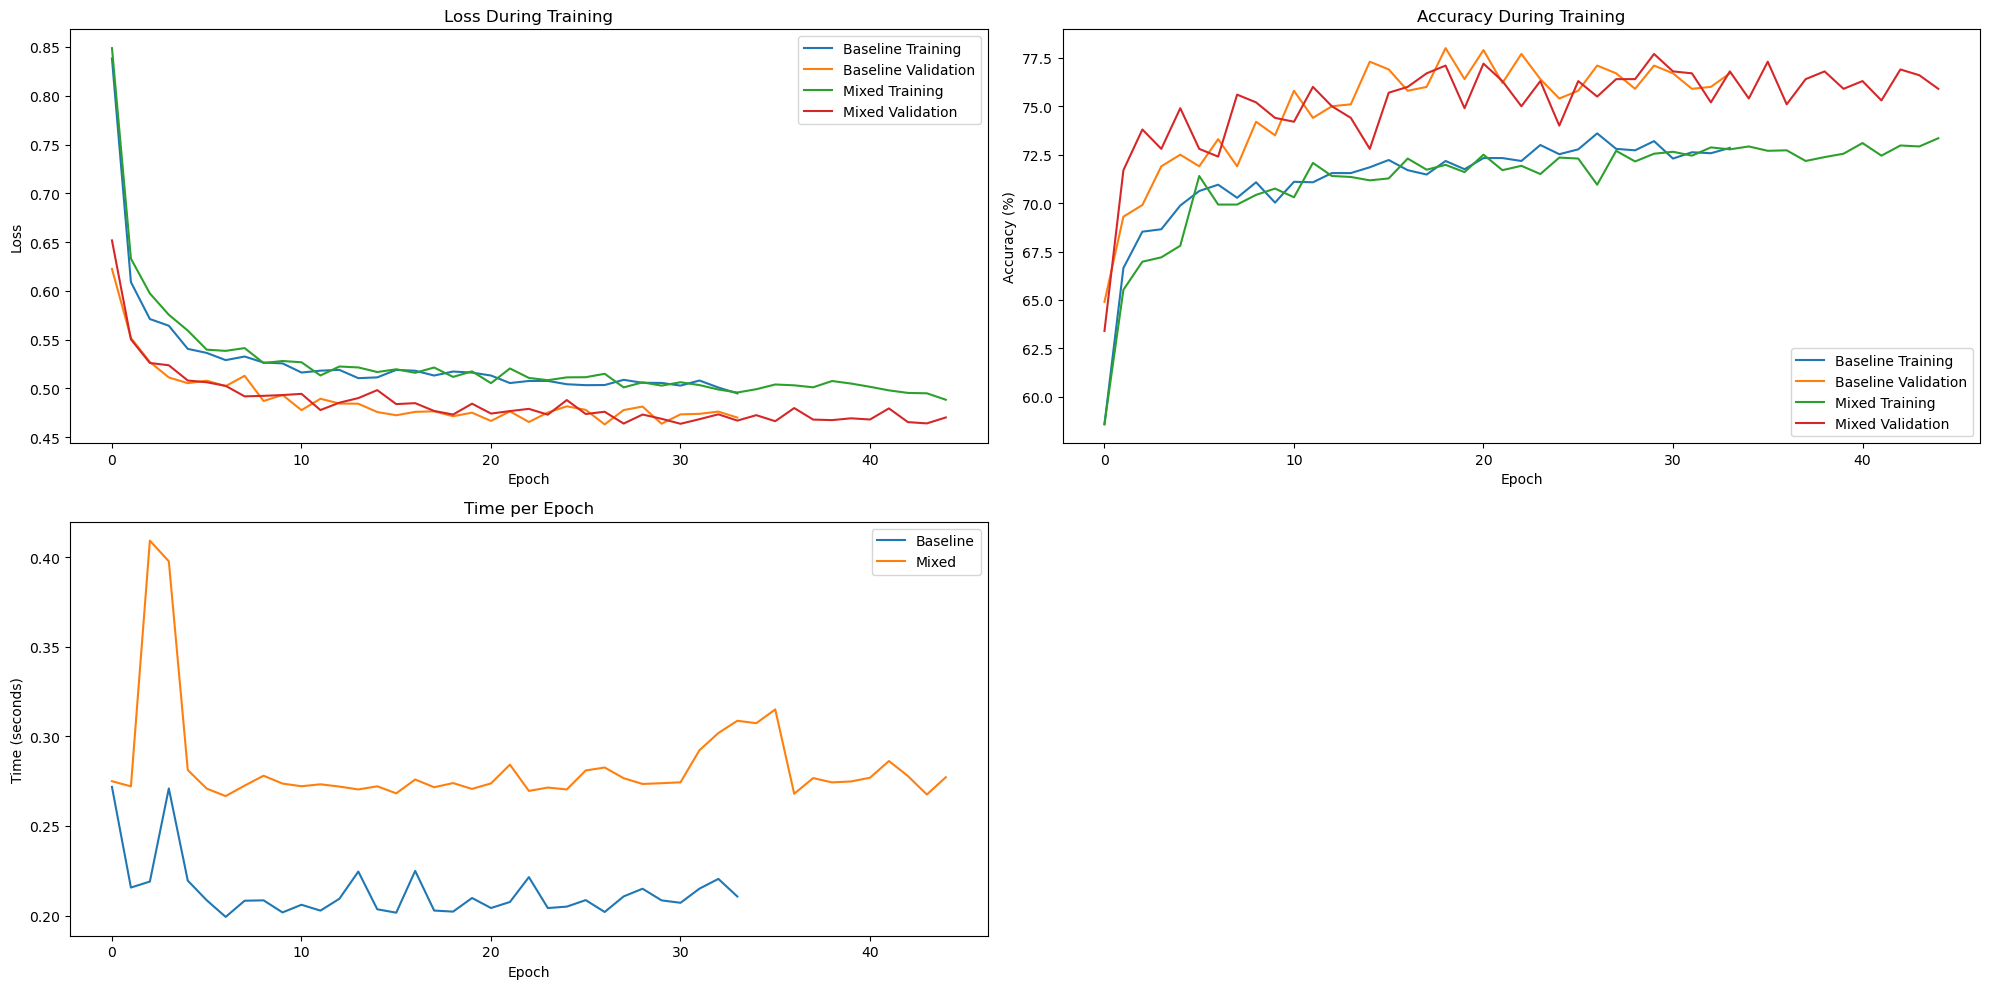

In [6]:
def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                           epochs=150, device='cpu', early_stop_patience=15,
                           accuracy_milestones=[0.70, 0.80, 0.85, 0.90]):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    epoch_times = []
    
    best_val_acc = 0
    best_state = None
    epochs_without_improvement = 0
    
    # Initialize dictionary to store when we hit accuracy milestones
    milestone_epochs = {acc: None for acc in accuracy_milestones}
    milestone_times = {acc: None for acc in accuracy_milestones}
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted == y_batch).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        epoch_times.append(epoch_time)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Check accuracy milestones
        elapsed_time = epoch_end - start_time
        for acc in accuracy_milestones:
            if milestone_epochs[acc] is None and val_acc >= acc:
                milestone_epochs[acc] = epoch + 1
                milestone_times[acc] = elapsed_time
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, '
                  f'Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, '
                  f'Time = {epoch_time:.2f}s')
    
    total_time = time.time() - start_time
    
    # Restore best model
    model.load_state_dict(best_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'epoch_times': epoch_times,
        'total_time': total_time,
        'milestone_epochs': milestone_epochs,
        'milestone_times': milestone_times,
        'best_val_acc': best_val_acc
    }

# Generate and prepare data
print("Generating dataset...")
X, y = generate_spirals(1000, 5, noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train both models
print("\nTraining Baseline Model...")
baseline_model = ComplexBaselineModel(num_classes=5).to(device)
baseline_optimizer = optim.AdamW(baseline_model.parameters(), lr=0.001, weight_decay=0.01)
baseline_scheduler = optim.lr_scheduler.ReduceLROnPlateau(baseline_optimizer, mode='min', factor=0.5, patience=10)
baseline_results = train_model_with_metrics(
    baseline_model, train_loader, test_loader, 
    nn.CrossEntropyLoss(), baseline_optimizer, baseline_scheduler
)

print("\nTraining Mixed Activation Model...")
mixed_model = ComplexMixedModel(num_classes=5).to(device)
mixed_optimizer = optim.AdamW(mixed_model.parameters(), lr=0.001, weight_decay=0.01)
mixed_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mixed_optimizer, mode='min', factor=0.5, patience=10)
mixed_results = train_model_with_metrics(
    mixed_model, train_loader, test_loader,
    nn.CrossEntropyLoss(), mixed_optimizer, mixed_scheduler
)

# Plotting results
plt.figure(figsize=(20, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(baseline_results['train_losses'], label='Baseline Training')
plt.plot(baseline_results['val_losses'], label='Baseline Validation')
plt.plot(mixed_results['train_losses'], label='Mixed Training')
plt.plot(mixed_results['val_losses'], label='Mixed Validation')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(baseline_results['train_accs'], label='Baseline Training')
plt.plot(baseline_results['val_accs'], label='Baseline Validation')
plt.plot(mixed_results['train_accs'], label='Mixed Training')
plt.plot(mixed_results['val_accs'], label='Mixed Validation')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Epoch time plot
plt.subplot(2, 2, 3)
plt.plot(baseline_results['epoch_times'], label='Baseline')
plt.plot(mixed_results['epoch_times'], label='Mixed')
plt.title('Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

# Print speed comparison results
print("\nSpeed Comparison Results:")
print("\nTime to reach accuracy thresholds:")
print(f"{'Accuracy':>10} {'Baseline':>12} {'Mixed':>12} {'Difference':>12}")
print("-" * 48)
for acc in sorted(baseline_results['milestone_epochs'].keys()):
    baseline_epoch = baseline_results['milestone_epochs'][acc]
    mixed_epoch = mixed_results['milestone_epochs'][acc]
    baseline_time = baseline_results['milestone_times'][acc]
    mixed_time = mixed_results['milestone_times'][acc]
    
    if baseline_epoch and mixed_epoch:
        epoch_diff = baseline_epoch - mixed_epoch
        time_diff = baseline_time - mixed_time
        print(f"{acc:>10}% {baseline_epoch:>12d} {mixed_epoch:>12d} {epoch_diff:>12d} epochs")
        print(f"{'time (s)':>10} {baseline_time:>12.2f} {mixed_time:>12.2f} {time_diff:>12.2f} sec")
    else:
        print(f"{acc:>10}% {'Not reached':>12} {'Not reached':>12} {'N/A':>12}")

print("\nTotal training time:")
print(f"Baseline: {baseline_results['total_time']:.2f} seconds")
print(f"Mixed: {mixed_results['total_time']:.2f} seconds")
print(f"Difference: {baseline_results['total_time'] - mixed_results['total_time']:.2f} seconds")

print("\nBest validation accuracy:")
print(f"Baseline: {baseline_results['best_val_acc']:.2f}%")
print(f"Mixed: {mixed_results['best_val_acc']:.2f}%")

plt.tight_layout()
plt.show()

Generating dataset...
Using device: cpu

Training Baseline Model...
Epoch 0: Train Loss = 0.824656, Val Loss = 0.685950, Time = 0.82s
Epoch 10: Train Loss = 0.469698, Val Loss = 0.348470, Time = 0.76s
Epoch 20: Train Loss = 0.377481, Val Loss = 0.257228, Time = 0.77s
Epoch 30: Train Loss = 0.332848, Val Loss = 0.207780, Time = 0.83s
Epoch 40: Train Loss = 0.302325, Val Loss = 0.196200, Time = 0.82s
Epoch 50: Train Loss = 0.270437, Val Loss = 0.194414, Time = 0.84s
Epoch 60: Train Loss = 0.246575, Val Loss = 0.154639, Time = 0.78s
Epoch 70: Train Loss = 0.221720, Val Loss = 0.141984, Time = 0.95s
Epoch 80: Train Loss = 0.204073, Val Loss = 0.122563, Time = 0.97s
Epoch 90: Train Loss = 0.184684, Val Loss = 0.093810, Time = 0.81s
Epoch 100: Train Loss = 0.151178, Val Loss = 0.060874, Time = 0.79s
Epoch 110: Train Loss = 0.141214, Val Loss = 0.052473, Time = 0.83s
Epoch 120: Train Loss = 0.129604, Val Loss = 0.047306, Time = 0.82s
Epoch 130: Train Loss = 0.120001, Val Loss = 0.045609, Time

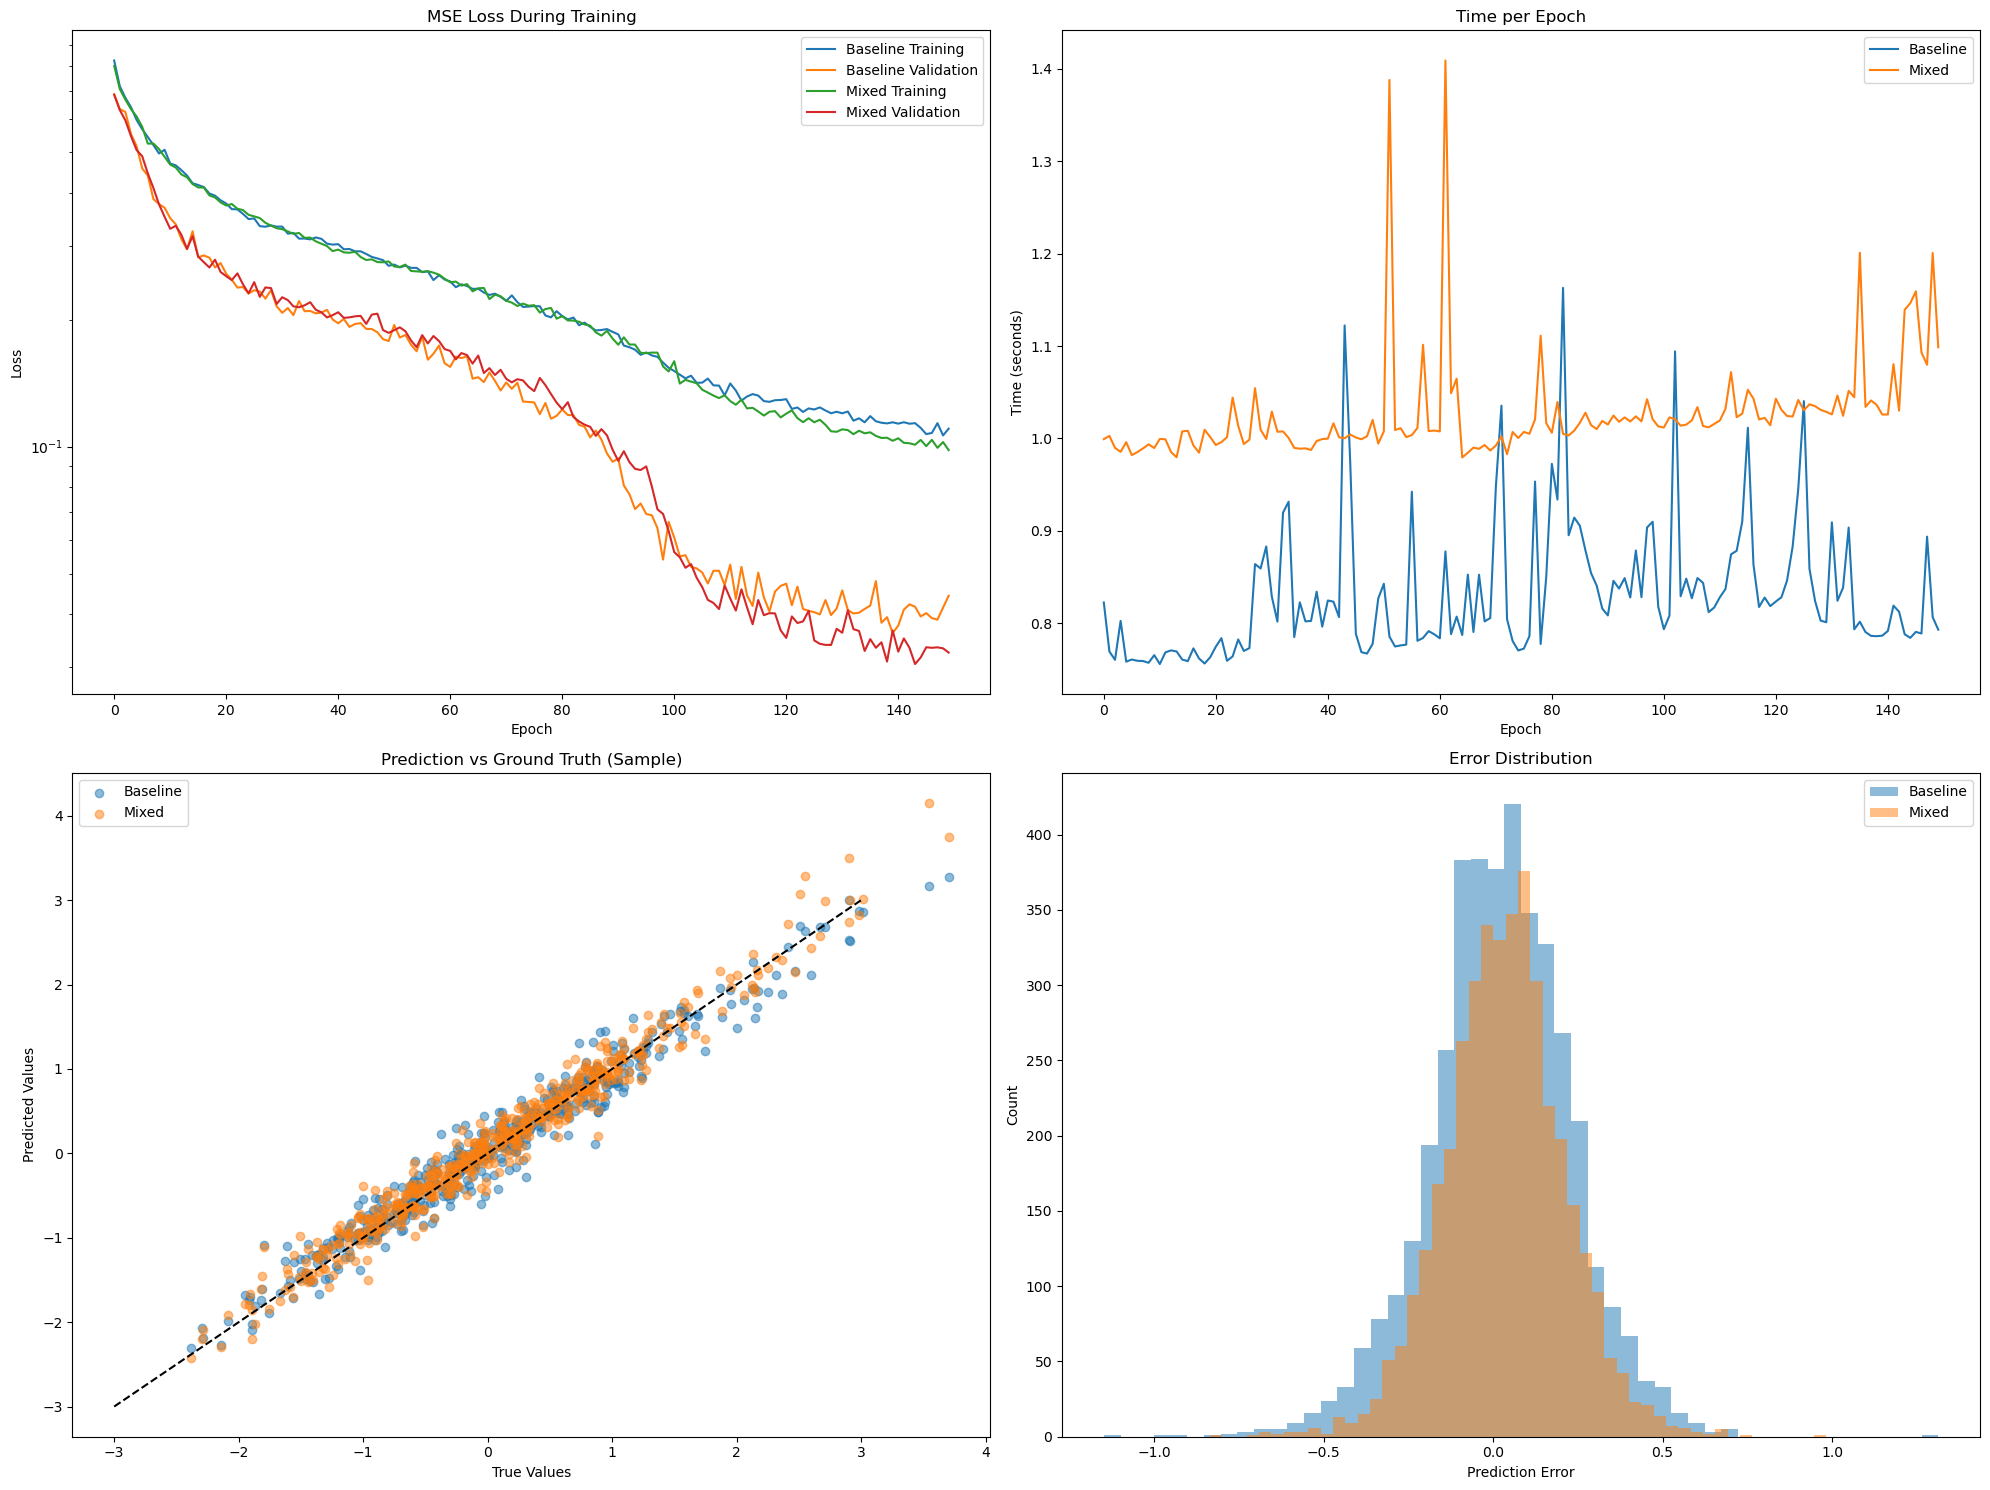

In [7]:
# Generate complex multivariate regression data
def generate_complex_data(n_samples=10000):
    np.random.seed(42)
    
    # Generate 5D input
    X = np.random.uniform(-4, 4, (n_samples, 5))
    
    # Create complex target function with multiple components
    y = (
        # Periodic components
        3.0 * np.sin(X[:, 0] * 2.0) * np.cos(X[:, 1] * 1.5) +
        # Non-linear interactions
        0.5 * X[:, 0]**2 * np.exp(-abs(X[:, 1])) +
        # Step functions and discontinuities
        2.0 * (X[:, 2] > 0).astype(float) * np.sin(X[:, 3] * 3.0) +
        # Exponential decay
        1.5 * np.exp(-0.5 * (X[:, 4]**2)) +
        # Local patterns
        0.8 * np.tanh(X[:, 0] * X[:, 1]) +
        # High-frequency components
        0.3 * np.sin(5.0 * X[:, 2]) * np.cos(5.0 * X[:, 3]) +
        # Add some noise
        np.random.normal(0, 0.1, n_samples)
    )
    
    # Normalize output
    y = (y - y.mean()) / y.std()
    
    return X, y.reshape(-1, 1)

# Complex baseline model
class ComplexBaselineModel(nn.Module):
    def __init__(self):
        super(ComplexBaselineModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Mixed activation model
class ComplexMixedModel(nn.Module):
    def __init__(self):
        super(ComplexMixedModel, self).__init__()
        
        # First mixed layer
        self.mixed_layer1 = MixedActivationLayer(
            in_features=5,
            neurons_per_activation=[
                (nn.ReLU(), 86),
                (nn.Tanh(), 85),
                (nn.GELU(), 85)
            ]
        )
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second mixed layer
        self.mixed_layer2 = MixedActivationLayer(
            in_features=256,
            neurons_per_activation=[
                (nn.ReLU(), 171),
                (nn.Tanh(), 171),
                (nn.GELU(), 170)
            ]
        )
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.2)
        
        # Third mixed layer
        self.mixed_layer3 = MixedActivationLayer(
            in_features=512,
            neurons_per_activation=[
                (nn.ReLU(), 86),
                (nn.Tanh(), 85),
                (nn.GELU(), 85)
            ]
        )
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.2)
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = self.mixed_layer1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.mixed_layer2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = self.mixed_layer3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        
        return self.final_layers(x)

def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                           epochs=150, device='cpu', early_stop_patience=15,
                           mse_thresholds=[0.5, 0.3, 0.2, 0.1]):
    train_losses = []
    val_losses = []
    epoch_times = []
    
    best_val_loss = float('inf')
    best_state = None
    epochs_without_improvement = 0
    
    # Initialize dictionary to store when we hit MSE thresholds
    milestone_epochs = {mse: None for mse in mse_thresholds}
    milestone_times = {mse: None for mse in mse_thresholds}
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        epoch_times.append(epoch_time)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Check MSE thresholds
        elapsed_time = epoch_end - start_time
        for mse in mse_thresholds:
            if milestone_epochs[mse] is None and val_loss <= mse:
                milestone_epochs[mse] = epoch + 1
                milestone_times[mse] = elapsed_time
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, '
                  f'Time = {epoch_time:.2f}s')
    
    total_time = time.time() - start_time
    
    # Restore best model
    model.load_state_dict(best_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch_times': epoch_times,
        'total_time': total_time,
        'milestone_epochs': milestone_epochs,
        'milestone_times': milestone_times,
        'best_val_loss': best_val_loss
    }

# Generate and prepare data
print("Generating dataset...")
X, y = generate_complex_data(20000)  # Generate more data for this complex task
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train both models
print("\nTraining Baseline Model...")
baseline_model = ComplexBaselineModel().to(device)
baseline_optimizer = optim.AdamW(baseline_model.parameters(), lr=0.001, weight_decay=0.01)
baseline_scheduler = optim.lr_scheduler.ReduceLROnPlateau(baseline_optimizer, mode='min', factor=0.5, patience=10)
baseline_results = train_model_with_metrics(
    baseline_model, train_loader, test_loader, 
    nn.MSELoss(), baseline_optimizer, baseline_scheduler
)

print("\nTraining Mixed Activation Model...")
mixed_model = ComplexMixedModel().to(device)
mixed_optimizer = optim.AdamW(mixed_model.parameters(), lr=0.001, weight_decay=0.01)
mixed_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mixed_optimizer, mode='min', factor=0.5, patience=10)
mixed_results = train_model_with_metrics(
    mixed_model, train_loader, test_loader,
    nn.MSELoss(), mixed_optimizer, mixed_scheduler
)

# Plotting results
plt.figure(figsize=(20, 15))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(baseline_results['train_losses'], label='Baseline Training')
plt.plot(baseline_results['val_losses'], label='Baseline Validation')
plt.plot(mixed_results['train_losses'], label='Mixed Training')
plt.plot(mixed_results['val_losses'], label='Mixed Validation')
plt.title('MSE Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Use log scale for better visualization
plt.legend()

# Epoch time plot
plt.subplot(2, 2, 2)
plt.plot(baseline_results['epoch_times'], label='Baseline')
plt.plot(mixed_results['epoch_times'], label='Mixed')
plt.title('Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

# Prediction scatter plot
plt.subplot(2, 2, 3)
with torch.no_grad():
    baseline_preds = baseline_model(X_test.to(device)).cpu().numpy()
    mixed_preds = mixed_model(X_test.to(device)).cpu().numpy()

plt.scatter(y_test[:500], baseline_preds[:500], alpha=0.5, label='Baseline')
plt.scatter(y_test[:500], mixed_preds[:500], alpha=0.5, label='Mixed')
plt.plot([-3, 3], [-3, 3], 'k--')  # Perfect prediction line
plt.title('Prediction vs Ground Truth (Sample)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

# Error distribution
plt.subplot(2, 2, 4)
baseline_errors = (baseline_preds - y_test.numpy()).flatten()
mixed_errors = (mixed_preds - y_test.numpy()).flatten()
plt.hist(baseline_errors, bins=50, alpha=0.5, label='Baseline')
plt.hist(mixed_errors, bins=50, alpha=0.5, label='Mixed')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.legend()

# Print speed comparison results
print("\nSpeed Comparison Results:")
print("\nTime to reach MSE thresholds:")
print(f"{'MSE':>10} {'Baseline':>12} {'Mixed':>12} {'Difference':>12}")
print("-" * 48)
for mse in sorted(baseline_results['milestone_epochs'].keys(), reverse=True):
    baseline_epoch = baseline_results['milestone_epochs'][mse]
    mixed_epoch = mixed_results['milestone_epochs'][mse]
    baseline_time = baseline_results['milestone_times'][mse]
    mixed_time = mixed_results['milestone_times'][mse]
    
    if baseline_epoch and mixed_epoch:
        epoch_diff = baseline_epoch - mixed_epoch
        time_diff = baseline_time - mixed_time
        print(f"{mse:>10.3f} {baseline_epoch:>12d} {mixed_epoch:>12d} {epoch_diff:>12d} epochs")
        print(f"{'time (s)':>10} {baseline_time:>12.2f} {mixed_time:>12.2f} {time_diff:>12.2f} sec")
    else:
        print(f"{mse:>10.3f} {'Not reached':>12} {'Not reached':>12} {'N/A':>12}")

print("\nTotal training time:")
print(f"Baseline: {baseline_results['total_time']:.2f} seconds")
print(f"Mixed: {mixed_results['total_time']:.2f} seconds")
print(f"Difference: {baseline_results['total_time'] - mixed_results['total_time']:.2f} seconds")

print("\nBest validation MSE:")
print(f"Baseline: {baseline_results['best_val_loss']:.6f}")
print(f"Mixed: {mixed_results['best_val_loss']:.6f}")

plt.tight_layout()
plt.show()

Generating dataset...
Using device: cpu

Training ReLU Model...
Epoch 0: Train Loss = 0.816731, Val Loss = 0.739582, Time = 0.82s
Epoch 10: Train Loss = 0.468912, Val Loss = 0.353838, Time = 0.74s
Epoch 20: Train Loss = 0.373362, Val Loss = 0.242922, Time = 0.74s
Epoch 30: Train Loss = 0.317659, Val Loss = 0.213806, Time = 0.74s
Epoch 40: Train Loss = 0.300984, Val Loss = 0.206859, Time = 0.75s
Epoch 50: Train Loss = 0.272088, Val Loss = 0.191414, Time = 0.75s
Epoch 60: Train Loss = 0.248105, Val Loss = 0.159146, Time = 0.77s
Epoch 70: Train Loss = 0.232660, Val Loss = 0.161458, Time = 0.76s
Epoch 80: Train Loss = 0.213568, Val Loss = 0.146685, Time = 0.78s
Epoch 90: Train Loss = 0.201249, Val Loss = 0.131052, Time = 0.76s
Epoch 100: Train Loss = 0.183359, Val Loss = 0.103426, Time = 0.77s
Epoch 110: Train Loss = 0.159333, Val Loss = 0.061783, Time = 0.77s
Epoch 120: Train Loss = 0.137447, Val Loss = 0.052963, Time = 0.78s
Epoch 130: Train Loss = 0.130690, Val Loss = 0.047842, Time = 0

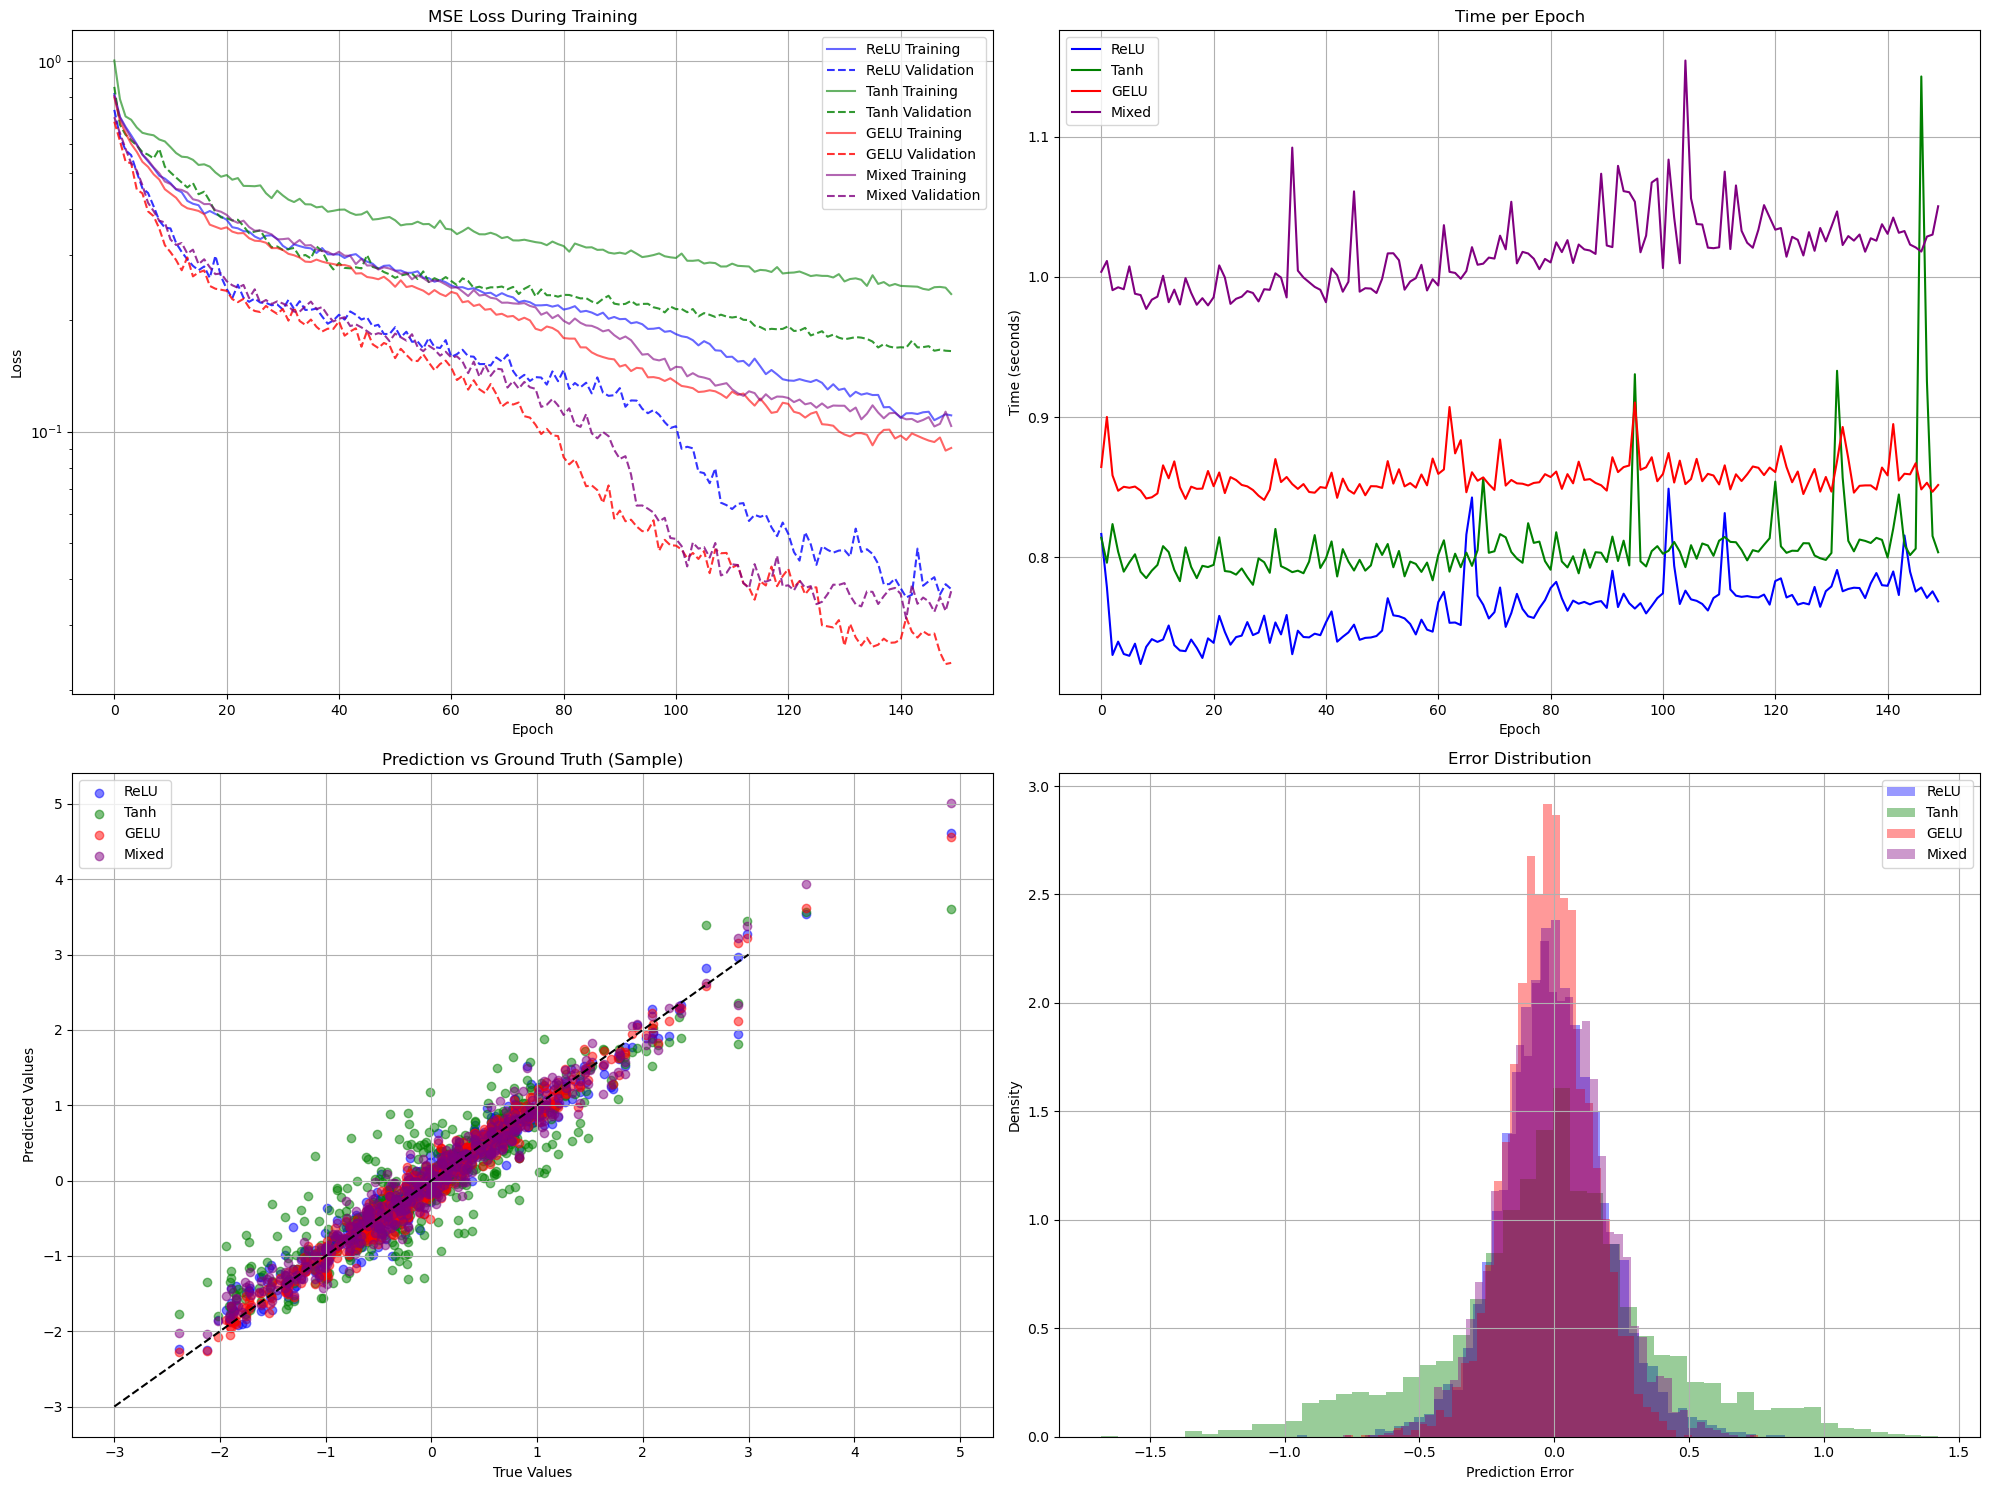


Comparative Results:

Model |   Best Val Loss |      Total Time | Time to 0.3 MSE | Time to 0.2 MSE | Time to 0.1 MSE
------------------------------------------------------------------------------------------------
ReLU  |        0.035660 |          114.5s | 10.436897277832031s | 29.029149770736694s | 77.18176078796387s
Tanh  |        0.165028 |          121.1s | 27.071079969406128s | 92.16109561920166s |             N/A
GELU  |        0.023566 |          128.6s | 10.265654802322388s | 27.31608748435974s | 65.84465789794922s
Mixed |        0.031238 |          152.5s | 15.874315738677979s | 39.76084089279175s | 86.18709015846252s

Relative Performance:

ReLU:
Loss ratio to best: 1.513x
Time ratio to fastest: 1.000x

Tanh:
Loss ratio to best: 7.003x
Time ratio to fastest: 1.058x

GELU:
Loss ratio to best: 1.000x
Time ratio to fastest: 1.123x

Mixed:
Loss ratio to best: 1.326x
Time ratio to fastest: 1.332x


In [8]:
# Base model template
class BaseModel(nn.Module):
    def __init__(self, activation_fn):
        super(BaseModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 256),
            activation_fn(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256, 512),
            activation_fn(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            activation_fn(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            activation_fn(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            activation_fn(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Model definitions using the base template
class ReLUModel(BaseModel):
    def __init__(self):
        super(ReLUModel, self).__init__(nn.ReLU)

class TanhModel(BaseModel):
    def __init__(self):
        super(TanhModel, self).__init__(nn.Tanh)

class GELUModel(BaseModel):
    def __init__(self):
        super(GELUModel, self).__init__(nn.GELU)

# Train multiple models and compare
def train_and_compare_models(X_train, y_train, X_test, y_test, device, batch_size=128):
    # Create data loaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize models
    models = {
        'ReLU': ReLUModel().to(device),
        'Tanh': TanhModel().to(device),
        'GELU': GELUModel().to(device),
        'Mixed': ComplexMixedModel().to(device)
    }
    
    results = {}
    
    # Train each model
    for name, model in models.items():
        print(f"\nTraining {name} Model...")
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        
        results[name] = train_model_with_metrics(
            model, train_loader, test_loader,
            nn.MSELoss(), optimizer, scheduler
        )
    
    return models, results

# Enhanced visualization function
def plot_comparative_results(results, X_test, y_test, models, device):
    plt.figure(figsize=(20, 15))
    colors = {'ReLU': 'blue', 'Tanh': 'green', 'GELU': 'red', 'Mixed': 'purple'}
    
    # Loss plot
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        plt.plot(result['train_losses'], 
                label=f'{name} Training',
                color=colors[name], linestyle='-', alpha=0.6)
        plt.plot(result['val_losses'],
                label=f'{name} Validation',
                color=colors[name], linestyle='--', alpha=0.8)
    plt.title('MSE Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # Epoch time plot
    plt.subplot(2, 2, 2)
    for name, result in results.items():
        plt.plot(result['epoch_times'],
                label=name,
                color=colors[name])
    plt.title('Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)

    # Prediction scatter plot
    plt.subplot(2, 2, 3)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    sample_indices = np.random.choice(len(X_test), 500, replace=False)
    
    with torch.no_grad():
        for name, model in models.items():
            preds = model(X_test_tensor).cpu().numpy()
            plt.scatter(y_test[sample_indices], 
                       preds[sample_indices],
                       alpha=0.5, label=name, color=colors[name])
    
    plt.plot([-3, 3], [-3, 3], 'k--')  # Perfect prediction line
    plt.title('Prediction vs Ground Truth (Sample)')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)

    # Error distribution
    plt.subplot(2, 2, 4)
    with torch.no_grad():
        for name, model in models.items():
            preds = model(X_test_tensor).cpu().numpy()
            errors = (preds - y_test).flatten()
            plt.hist(errors, bins=50, alpha=0.4,
                    label=name, color=colors[name],
                    density=True)  # Normalize for better comparison
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Print comparative metrics
def print_comparative_metrics(results):
    print("\nComparative Results:")
    
    # Table header
    models = list(results.keys())
    metrics = ['Best Val Loss', 'Total Time', 'Time to 0.3 MSE', 'Time to 0.2 MSE', 'Time to 0.1 MSE']
    
    # Calculate max lengths for formatting
    model_width = max(len(str(x)) for x in models)
    metric_width = max(len(str(x)) for x in metrics)
    
    # Print header
    print(f"\n{'Model':<{model_width}} | " + " | ".join(f"{metric:>{metric_width}}" for metric in metrics))
    print("-" * (model_width + sum([metric_width + 3 for metric in metrics]) + 1))
    
    # Print each model's results
    for model in models:
        r = results[model]
        values = [
            f"{r['best_val_loss']:.6f}",
            f"{r['total_time']:.1f}s",
            f"{r['milestone_times'].get(0.3, 'N/A')}s" if r['milestone_times'].get(0.3) else 'N/A',
            f"{r['milestone_times'].get(0.2, 'N/A')}s" if r['milestone_times'].get(0.2) else 'N/A',
            f"{r['milestone_times'].get(0.1, 'N/A')}s" if r['milestone_times'].get(0.1) else 'N/A'
        ]
        print(f"{model:<{model_width}} | " + " | ".join(f"{value:>{metric_width}}" for value in values))

    # Print relative performance
    best_val_loss = min(r['best_val_loss'] for r in results.values())
    fastest_time = min(r['total_time'] for r in results.values())
    
    print("\nRelative Performance:")
    for model in models:
        r = results[model]
        val_loss_ratio = r['best_val_loss'] / best_val_loss
        time_ratio = r['total_time'] / fastest_time
        print(f"\n{model}:")
        print(f"Loss ratio to best: {val_loss_ratio:.3f}x")
        print(f"Time ratio to fastest: {time_ratio:.3f}x")

# Main execution
print("Generating dataset...")
X, y = generate_complex_data(20000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train all models
models, results = train_and_compare_models(X_train, y_train, X_test, y_test, device)

# Visualize results
plot_comparative_results(results, X_test, y_test, models, device)

# Print metrics
print_comparative_metrics(results)